# Data Visualization
By Intern: Diego Varela, Mentor: Surendra Adhikari

Libraries Used

In [175]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [176]:
import numpy as np
import scipy
import pandas as pd
import datetime
import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import imageio



Helper Functions:

In [177]:
data_folder = '/Users/dlugardo/Desktop/data/ENU_v2' # path to the folder with the data 

def get_data(location):
    file_name = str(location) + '.ENU.txt'
    path = os.path.join(data_folder, file_name)

    if os.path.isfile(path):
        data = np.loadtxt(path, skiprows=2)
    else:
        file_name = str(location) + '_ENU.txt'
        path = os.path.join(data_folder, file_name)

        if os.path.isfile(path):
            data = np.loadtxt(path, skiprows=2)
        else:
            raise FileNotFoundError(f"Neither '{location}.ENU.txt' nor '{location}_ENU.txt' found in {data_folder}")
    return data

In [178]:
def decimal_year_to_date(decimal_year):
    """
    Converts a decimal year to a datetime.date object.
    """
    year = int(decimal_year)
    fractional_part = decimal_year - year

    # Determine if it's a leap year for accurate day calculation
    is_leap = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    days_in_year = 366 if is_leap else 365

    # Calculate the number of days from the start of the year
    days_offset = fractional_part * days_in_year

    # Create a datetime object for January 1st of that year
    start_of_year = datetime.date(year, 1, 1)

    # Add the calculated offset in days
    result_date = start_of_year + datetime.timedelta(days=days_offset)

    return result_date


In [179]:
StationMetaData = df = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/GreenlandStations.csv')
StationMetaData

station   latitude  longitude  elevation_m  is_greenland
0     NGFJ  80.568475 -16.841131         35.5          True
1     JWLF  83.111656 -45.119847        112.9          True
2     THU4  76.537106 -68.824953         36.2          True
3     JGBL  82.208758 -31.004208        753.3          True
4     THU2  76.537047 -68.825050         36.2          True
..     ...        ...        ...          ...           ...
71    MIK2  68.140281 -31.451825        815.9          True
72    KUAQ  68.587000 -33.052750        865.2          True
73    KSUT  64.070697 -52.007697         40.7          True
74    RINK  71.848500 -50.993967       1337.9          True
75    NRSK  79.155031 -17.725419        348.0          True

[76 rows x 5 columns]

In [201]:
## LTM Creation
from datetime import timedelta

stations_names_with_data = []
metadata_records = []

MAX_GAP_DAYS = 14  # maximum acceptable gap (in days)

def find_longest_continuous_segment(dates, max_gap_days=14):
    # Ensure dates are sorted
    dates = np.sort(dates)
    segments = []
    current_segment = [dates[0]]

    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days <= max_gap_days:
            current_segment.append(dates[i])
        else:
            segments.append(current_segment)
            current_segment = [dates[i]]
    segments.append(current_segment)

    # Return the longest continuous segment
    return max(segments, key=len)

for station_name in StationMetaData.station:
    try:
        raw_data = get_data(station_name)
        time = raw_data[:, 0]
        converted_dates = np.array([decimal_year_to_date(dy) for dy in time])

        # Find longest continuous segment of data
        continuous_segment = find_longest_continuous_segment(converted_dates, max_gap_days=MAX_GAP_DAYS)

        if len(continuous_segment) < 365 * 5:  # optional: skip if segment is too short
            print(f"  → Skipping {station_name}: continuous segment too short.")
            continue

        # Filter both data and error to this segment
        mask = np.isin(converted_dates, continuous_segment)
        data = raw_data[mask, 1:4]
        error = raw_data[mask, 4:]
        converted_dates = converted_dates[mask]
        
        # Detrend data
        data_detrended = scipy.signal.detrend(data, axis=0)

        # Build DataFrame
        df = pd.DataFrame({'time': converted_dates})
        df['east'] = data_detrended[:, 0]
        df['north'] = data_detrended[:, 1]
        df['up'] = data_detrended[:, 2]
        df.set_index('time', inplace=True)

        # Compute monthly climatology
        df['month_day'] = df.index.map(lambda x: x.strftime('%m-%d'))
        climatology = df.groupby('month_day')[['east', 'north', 'up']].mean()
        df['month'] = df.index.map(lambda x: x.strftime('%m'))
        climatology_monthly = df.groupby('month')[['east', 'north', 'up']].mean()

        climatology_monthly.to_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station_name + '_LTM.csv', index = False) 
        
        start_date = continuous_segment[0]
        end_date = continuous_segment[-1]
        duration_years = round((end_date - start_date).days / 365.25, 2)

        metadata_records.append({
            'station': station_name,
            'start_date': start_date.strftime('%Y-%m-%d'),
            'end_date': end_date.strftime('%Y-%m-%d'),
            'years_of_data': duration_years
        })

        stations_names_with_data.append(station_name)

    except FileNotFoundError:
        print(f"  → File not found for station {station_name}. Skipping.")
        continue
    except Exception as e:
        print(f"  → Error processing station {station_name}: {e}")
        continue

metadata_df = pd.DataFrame(metadata_records)
metadata_df.to_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/LTM_station_metadata.csv', index=False)

  → Skipping NGFJ: continuous segment too short.
  → File not found for station THU4. Skipping.
  → File not found for station QENU. Skipping.
  → File not found for station AAS2. Skipping.
  → Skipping EQNU: continuous segment too short.
  → Skipping ISOR: continuous segment too short.
  → Skipping TIMM: continuous segment too short.
  → Skipping KLY2: continuous segment too short.
  → Skipping SCOB: continuous segment too short.
  → File not found for station SCO4. Skipping.
  → File not found for station STNO. Skipping.
  → File not found for station QAQ2. Skipping.
  → File not found for station KLQ3. Skipping.
  → Skipping KULU: continuous segment too short.
  → Skipping UPAK: continuous segment too short.
  → Skipping AVAN: continuous segment too short.
  → Skipping KAPI: continuous segment too short.
  → Skipping THU1: continuous segment too short.
  → File not found for station THU3. Skipping.
  → Skipping NUNA: continuous segment too short.
  → File not found for station KSUT.

JWLF @ Jan: U=[-0.0952844], V=[0.06087897], Mag=[0.11307239]
JGBL @ Jan: U=[0.2746307], V=[0.27060702], Mag=[0.38555179]
THU2 @ Jan: U=[0.3380411], V=[-0.18508145], Mag=[0.38539191]
NNVN @ Jan: U=[2.41911877], V=[-0.42676823], Mag=[2.45647445]
YMER @ Jan: U=[0.63313804], V=[-0.40525963], Mag=[0.75173077]
KMOR @ Jan: U=[-0.48288006], V=[0.74674062], Mag=[0.88926639]
BLAS @ Jan: U=[0.57935626], V=[-0.09106277], Mag=[0.58646918]
KLSQ @ Jan: U=[-0.47614764], V=[-0.88204968], Mag=[1.00236132]
MARG @ Jan: U=[0.0845974], V=[-0.41697453], Mag=[0.42546972]
HRDG @ Jan: U=[0.02117741], V=[-0.05785186], Mag=[0.06160617]
KELY @ Jan: U=[-0.29331242], V=[-0.66034933], Mag=[0.72256031]
ILUL @ Jan: U=[-0.58016158], V=[-0.27760185], Mag=[0.64315647]
KBUG @ Jan: U=[0.38758933], V=[0.23186244], Mag=[0.45164774]
DGJG @ Jan: U=[0.6244453], V=[-0.11971056], Mag=[0.63581645]
WTHG @ Jan: U=[0.49999326], V=[-0.25710809], Mag=[0.56222579]
AASI @ Jan: U=[-0.34761053], V=[-0.52742837], Mag=[0.63167537]
HJOR @ Jan:

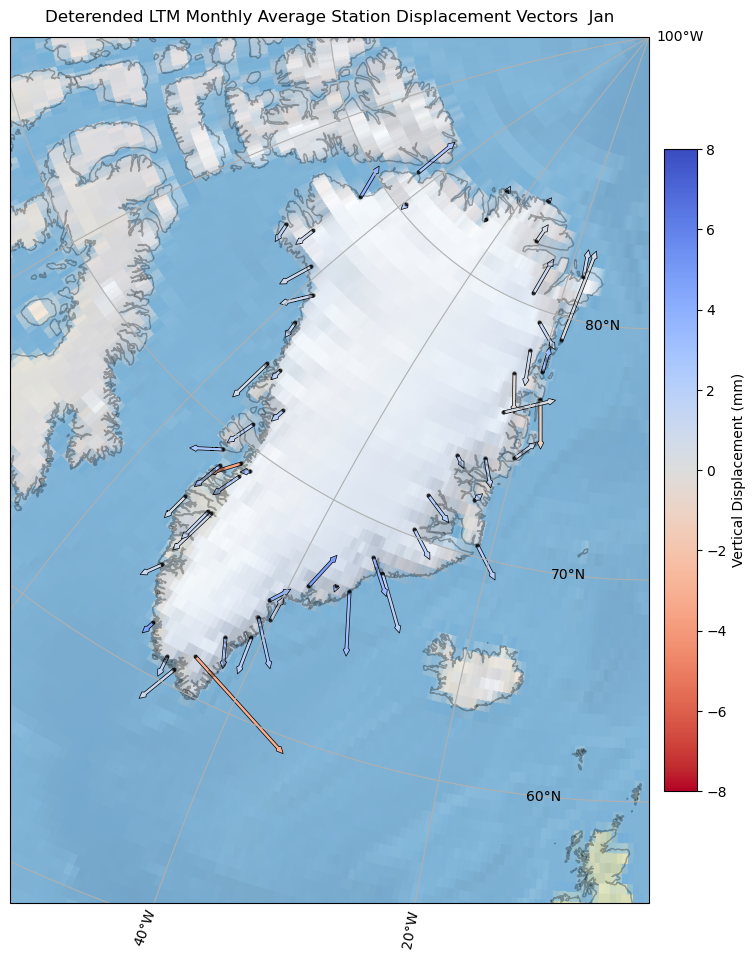

JWLF @ Feb: U=[0.12892642], V=[0.46959555], Mag=[0.48697229]
JGBL @ Feb: U=[0.53263649], V=[0.10740121], Mag=[0.54335684]
THU2 @ Feb: U=[0.92360804], V=[-0.14565587], Mag=[0.9350227]
NNVN @ Feb: U=[2.46021633], V=[-1.92051257], Mag=[3.12106279]
YMER @ Feb: U=[2.74433907], V=[0.24012687], Mag=[2.75482446]
KMOR @ Feb: U=[-0.62332539], V=[-1.0060241], Mag=[1.18347752]
BLAS @ Feb: U=[0.99603079], V=[-0.41514063], Mag=[1.07908251]
KLSQ @ Feb: U=[0.01945854], V=[-0.38776642], Mag=[0.38825433]
MARG @ Feb: U=[0.11351059], V=[-0.34528296], Mag=[0.36346249]
HRDG @ Feb: U=[0.23737609], V=[0.27741299], Mag=[0.36511008]
KELY @ Feb: U=[0.11882738], V=[-1.27519324], Mag=[1.28071766]
ILUL @ Feb: U=[-0.13046733], V=[-0.03197349], Mag=[0.13432807]
KBUG @ Feb: U=[0.86845366], V=[-0.00103425], Mag=[0.86845428]
DGJG @ Feb: U=[1.12672692], V=[-0.45857902], Mag=[1.2164737]
WTHG @ Feb: U=[0.84039477], V=[-0.58594314], Mag=[1.02449633]
AASI @ Feb: U=[-1.62356146], V=[-0.84845522], Mag=[1.83189194]
HJOR @ Feb: 

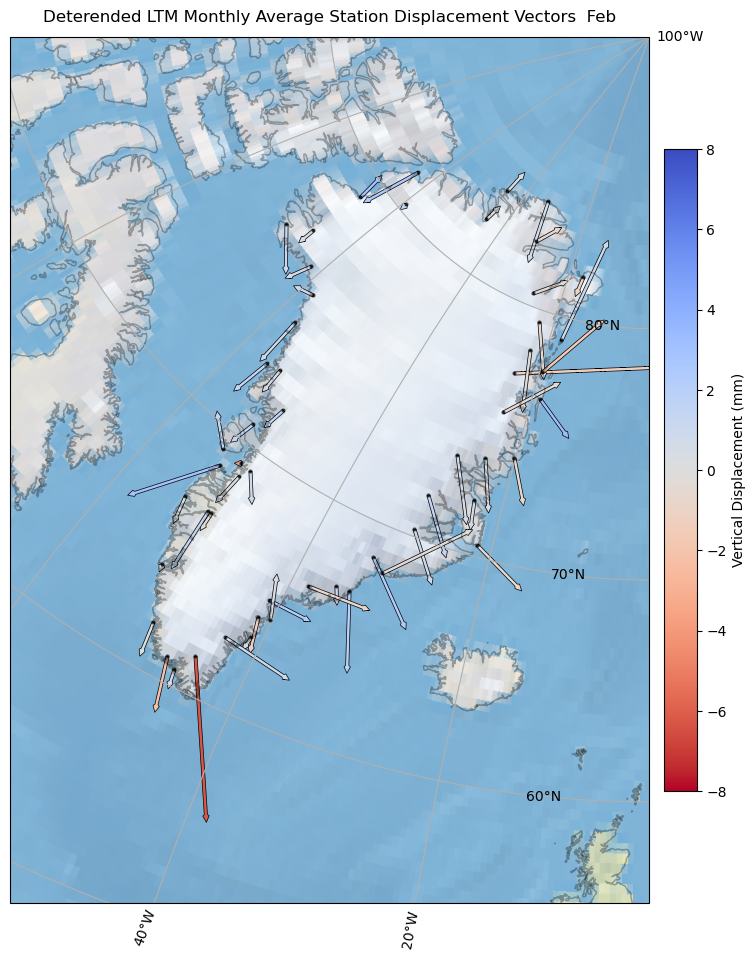

JWLF @ Mar: U=[3.85907692e-05], V=[-0.07251811], Mag=[0.07251812]
JGBL @ Mar: U=[0.21551993], V=[-0.3400488], Mag=[0.40259412]
THU2 @ Mar: U=[1.02063239], V=[0.00417905], Mag=[1.02064094]
NNVN @ Mar: U=[1.63569114], V=[-3.20733278], Mag=[3.60034291]
YMER @ Mar: U=[2.12875708], V=[0.14526141], Mag=[2.13370748]
KMOR @ Mar: U=[-2.05875722], V=[-2.04227248], Mag=[2.89988933]
BLAS @ Mar: U=[0.45278736], V=[-0.47760863], Mag=[0.65812339]
KLSQ @ Mar: U=[0.10584114], V=[-0.25388059], Mag=[0.27505945]
MARG @ Mar: U=[0.02414027], V=[-0.41761599], Mag=[0.41831312]
HRDG @ Mar: U=[-0.03808489], V=[0.20861029], Mag=[0.21205828]
KELY @ Mar: U=[0.67775103], V=[-0.76640058], Mag=[1.02309154]
ILUL @ Mar: U=[0.29315695], V=[-0.91497115], Mag=[0.9607878]
KBUG @ Mar: U=[-0.03941208], V=[-0.72475365], Mag=[0.72582447]
DGJG @ Mar: U=[1.19076119], V=[-0.61220995], Mag=[1.33892241]
WTHG @ Mar: U=[0.53317164], V=[-0.83162925], Mag=[0.98786599]
AASI @ Mar: U=[-1.20456206], V=[-1.16970513], Mag=[1.67904135]
HJOR 

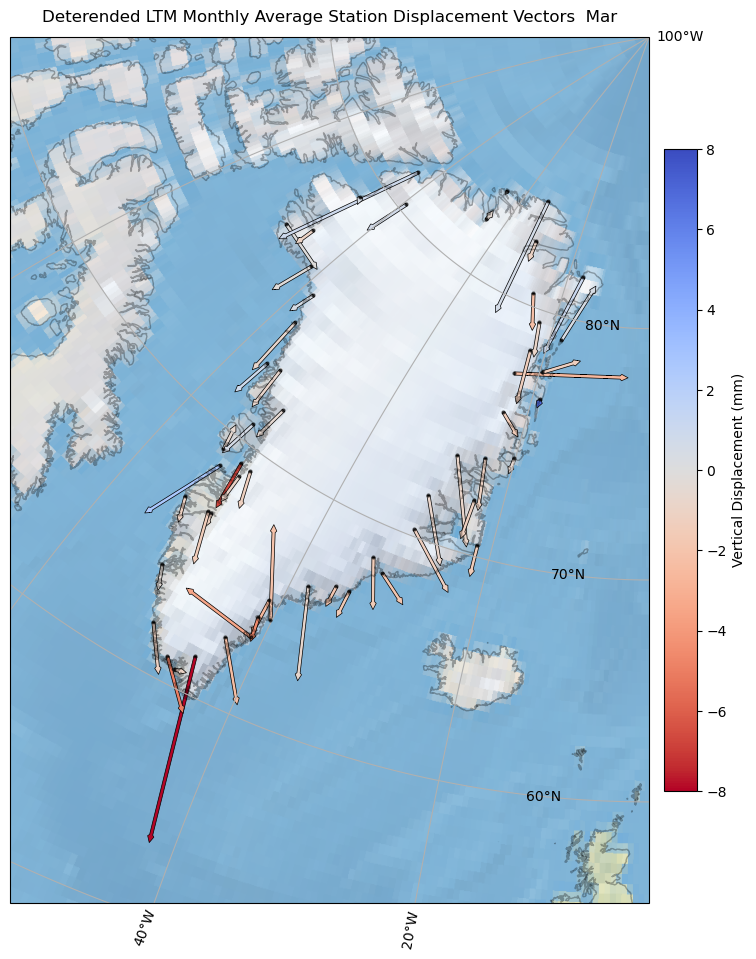

JWLF @ Apr: U=[0.03030117], V=[-0.36979623], Mag=[0.37103559]
JGBL @ Apr: U=[-0.16331734], V=[-0.15718114], Mag=[0.22666818]
THU2 @ Apr: U=[0.2861159], V=[0.27668528], Mag=[0.3980164]
NNVN @ Apr: U=[0.33328282], V=[-1.99769199], Mag=[2.02530263]
YMER @ Apr: U=[0.74157448], V=[0.817564], Mag=[1.10378603]
KMOR @ Apr: U=[-1.24575714], V=[-0.48506862], Mag=[1.33686291]
BLAS @ Apr: U=[-0.05891592], V=[-0.06335294], Mag=[0.08651405]
KLSQ @ Apr: U=[0.08646811], V=[0.09988076], Mag=[0.13210942]
MARG @ Apr: U=[-0.22045499], V=[0.20258411], Mag=[0.29940061]
HRDG @ Apr: U=[-0.39829302], V=[0.32624426], Mag=[0.51485206]
KELY @ Apr: U=[0.14186685], V=[-0.00922957], Mag=[0.14216676]
ILUL @ Apr: U=[0.4116552], V=[-0.32600436], Mag=[0.52510841]
KBUG @ Apr: U=[-0.87494753], V=[-0.07305022], Mag=[0.87799175]
DGJG @ Apr: U=[0.78578596], V=[0.1400106], Mag=[0.79816198]
WTHG @ Apr: U=[-0.06770476], V=[-0.2050699], Mag=[0.2159574]
AASI @ Apr: U=[-0.18572107], V=[-0.32144873], Mag=[0.37124332]
HJOR @ Apr: U=

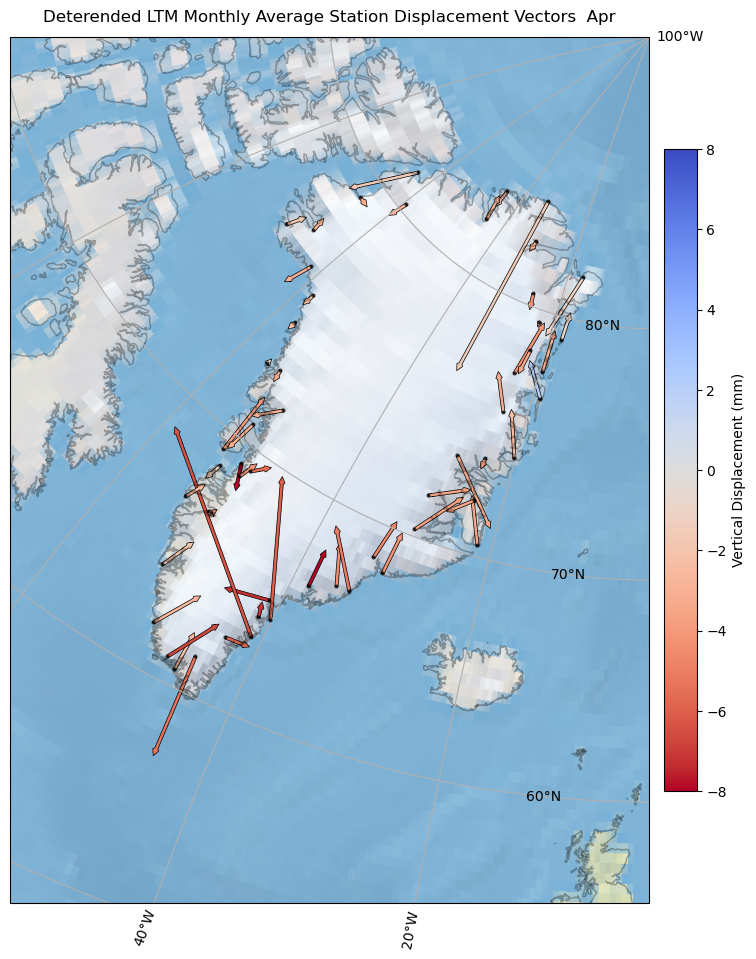

JWLF @ May: U=[0.24386977], V=[-0.30342383], Mag=[0.38927945]
JGBL @ May: U=[-0.32180351], V=[0.19099942], Mag=[0.37421688]
THU2 @ May: U=[-0.29602458], V=[0.44351748], Mag=[0.53323382]
NNVN @ May: U=[-1.50707632], V=[0.01050377], Mag=[1.50711292]
YMER @ May: U=[-0.8736664], V=[0.9382588], Mag=[1.28203844]
KMOR @ May: U=[0.22658277], V=[0.30746763], Mag=[0.38193729]
BLAS @ May: U=[0.06580031], V=[0.29043913], Mag=[0.29779954]
KLSQ @ May: U=[0.28723129], V=[0.49521016], Mag=[0.57248136]
MARG @ May: U=[-0.40459673], V=[0.65016255], Mag=[0.76577402]
HRDG @ May: U=[-0.37973926], V=[0.34618234], Mag=[0.51385223]
KELY @ May: U=[0.33389445], V=[0.49888938], Mag=[0.60031335]
ILUL @ May: U=[0.41274639], V=[0.04413106], Mag=[0.41509894]
KBUG @ May: U=[-1.16923482], V=[0.12453752], Mag=[1.17584849]
DGJG @ May: U=[0.4121445], V=[0.51586074], Mag=[0.66028433]
WTHG @ May: U=[-0.62743423], V=[0.156928], Mag=[0.64676125]
AASI @ May: U=[0.81722324], V=[0.25607258], Mag=[0.85640352]
HJOR @ May: U=[-4.26

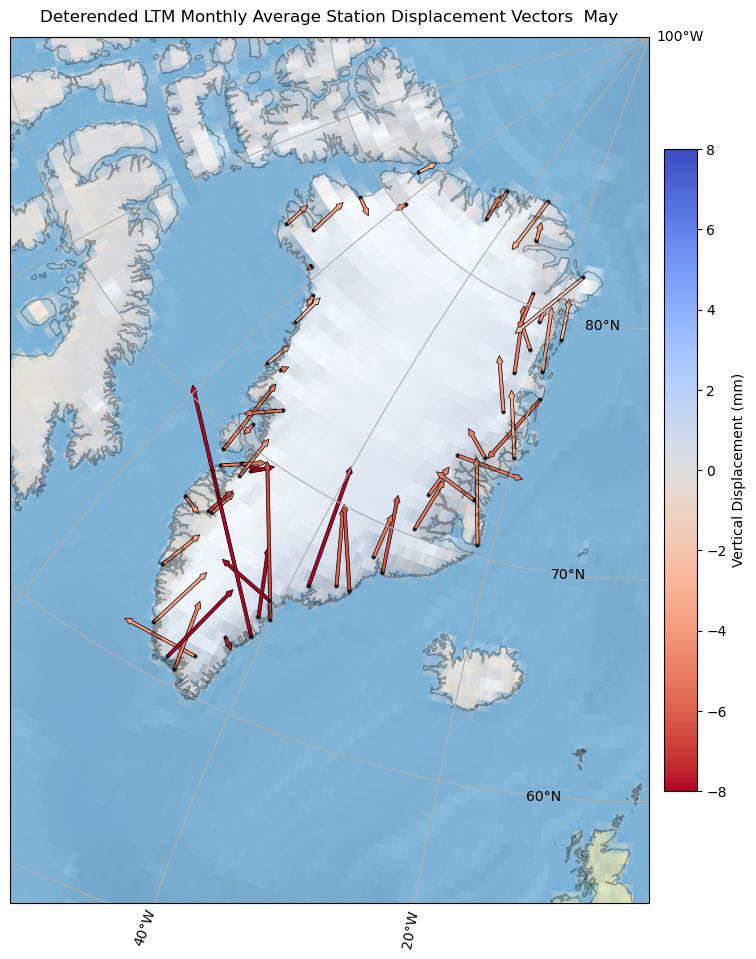

JWLF @ Jun: U=[0.28758944], V=[-1.14848811], Mag=[1.18394789]
JGBL @ Jun: U=[-0.3765727], V=[-0.18884638], Mag=[0.42127182]
THU2 @ Jun: U=[-0.44953672], V=[0.33979313], Mag=[0.56350922]
NNVN @ Jun: U=[-2.03326041], V=[0.55902781], Mag=[2.1087105]
YMER @ Jun: U=[-0.92393697], V=[0.4897696], Mag=[1.04572165]
KMOR @ Jun: U=[0.5813378], V=[-0.07447658], Mag=[0.58608908]
BLAS @ Jun: U=[-0.60843799], V=[0.31406764], Mag=[0.68471546]
KLSQ @ Jun: U=[0.79780106], V=[0.31620721], Mag=[0.85818036]
MARG @ Jun: U=[-0.09643227], V=[0.25816692], Mag=[0.27558908]
HRDG @ Jun: U=[-0.09986711], V=[-0.02652776], Mag=[0.10333035]
KELY @ Jun: U=[0.44067496], V=[0.42195037], Mag=[0.61011191]
ILUL @ Jun: U=[0.58940674], V=[-0.11560663], Mag=[0.60063732]
KBUG @ Jun: U=[-1.15423037], V=[-0.56317494], Mag=[1.28429504]
DGJG @ Jun: U=[-0.19171087], V=[0.12001339], Mag=[0.22617752]
WTHG @ Jun: U=[-0.78833116], V=[-0.05064535], Mag=[0.78995631]
AASI @ Jun: U=[0.90309234], V=[0.27107478], Mag=[0.94289835]
HJOR @ Jun:

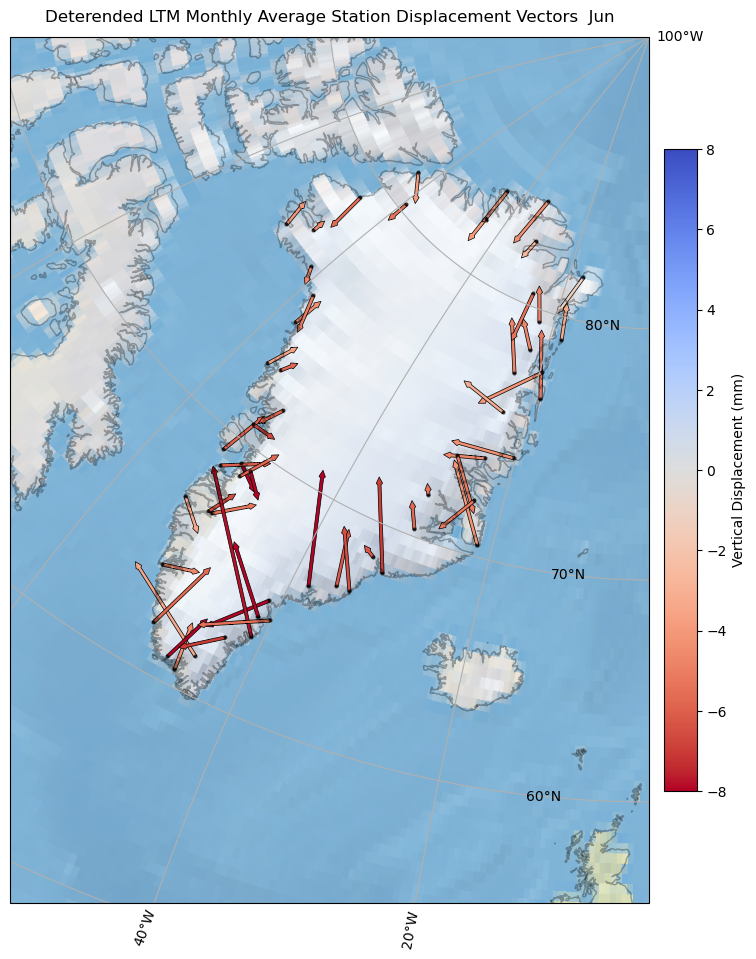

JWLF @ Jul: U=[0.05055149], V=[-0.93995314], Mag=[0.94131151]
JGBL @ Jul: U=[-0.46470852], V=[-0.09382729], Mag=[0.47408604]
THU2 @ Jul: U=[-0.50480686], V=[-0.07161122], Mag=[0.50986089]
NNVN @ Jul: U=[-2.00258042], V=[0.97297808], Mag=[2.22643542]
YMER @ Jul: U=[-1.02347721], V=[0.11195623], Mag=[1.02958234]
KMOR @ Jul: U=[0.81729486], V=[-0.03308568], Mag=[0.81796427]
BLAS @ Jul: U=[-0.6484795], V=[0.58277681], Mag=[0.87186838]
KLSQ @ Jul: U=[0.84795896], V=[0.64002756], Mag=[1.06238866]
MARG @ Jul: U=[0.07986817], V=[-0.21689841], Mag=[0.23113599]
HRDG @ Jul: U=[-0.05197132], V=[-0.06740153], Mag=[0.0851116]
KELY @ Jul: U=[0.33218509], V=[0.12104681], Mag=[0.35355235]
ILUL @ Jul: U=[0.43387036], V=[0.09647008], Mag=[0.44446593]
KBUG @ Jul: U=[-0.54979207], V=[-0.48832545], Mag=[0.73534554]
DGJG @ Jul: U=[-1.22560538], V=[-0.08791932], Mag=[1.2287548]
WTHG @ Jul: U=[-0.90932902], V=[0.06588682], Mag=[0.91171286]
AASI @ Jul: U=[0.66157296], V=[0.20273359], Mag=[0.69193908]
HJOR @ Jul

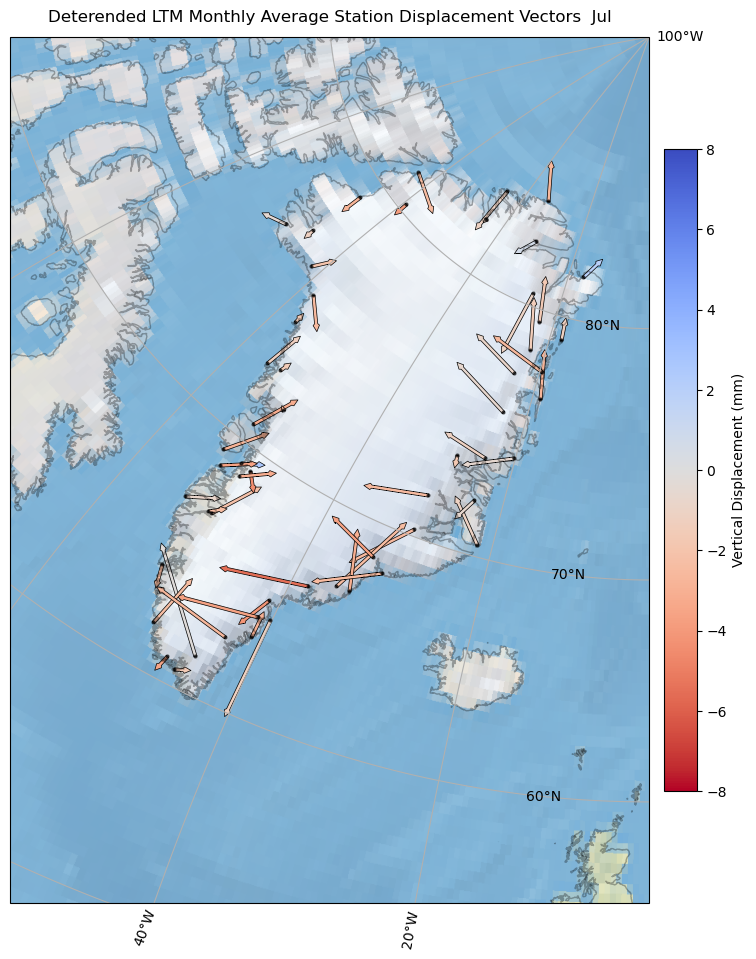

JWLF @ Aug: U=[0.00191345], V=[-0.21241862], Mag=[0.21242724]
JGBL @ Aug: U=[-0.15313596], V=[-0.28988663], Mag=[0.32784886]
THU2 @ Aug: U=[-0.4197921], V=[-0.27111352], Mag=[0.49972788]
NNVN @ Aug: U=[-1.65305569], V=[0.64033438], Mag=[1.77274399]
YMER @ Aug: U=[-1.03577161], V=[-0.03325718], Mag=[1.03630539]
KMOR @ Aug: U=[1.00037664], V=[0.34148342], Mag=[1.05705456]
BLAS @ Aug: U=[-0.20277601], V=[0.3594834], Mag=[0.41273045]
KLSQ @ Aug: U=[0.19662143], V=[0.5328409], Mag=[0.56796075]
MARG @ Aug: U=[0.35738736], V=[-0.01894577], Mag=[0.35788919]
HRDG @ Aug: U=[0.13535554], V=[-0.31660859], Mag=[0.3443285]
KELY @ Aug: U=[0.12797427], V=[0.57508276], Mag=[0.58914989]
ILUL @ Aug: U=[0.12450429], V=[0.13911585], Mag=[0.1866937]
KBUG @ Aug: U=[0.17800598], V=[-0.51757568], Mag=[0.54733054]
DGJG @ Aug: U=[-1.34085653], V=[-0.07529521], Mag=[1.34296895]
WTHG @ Aug: U=[-0.54217694], V=[0.16804323], Mag=[0.56762168]
AASI @ Aug: U=[0.33161441], V=[0.12770971], Mag=[0.355356]
HJOR @ Aug: U=[2

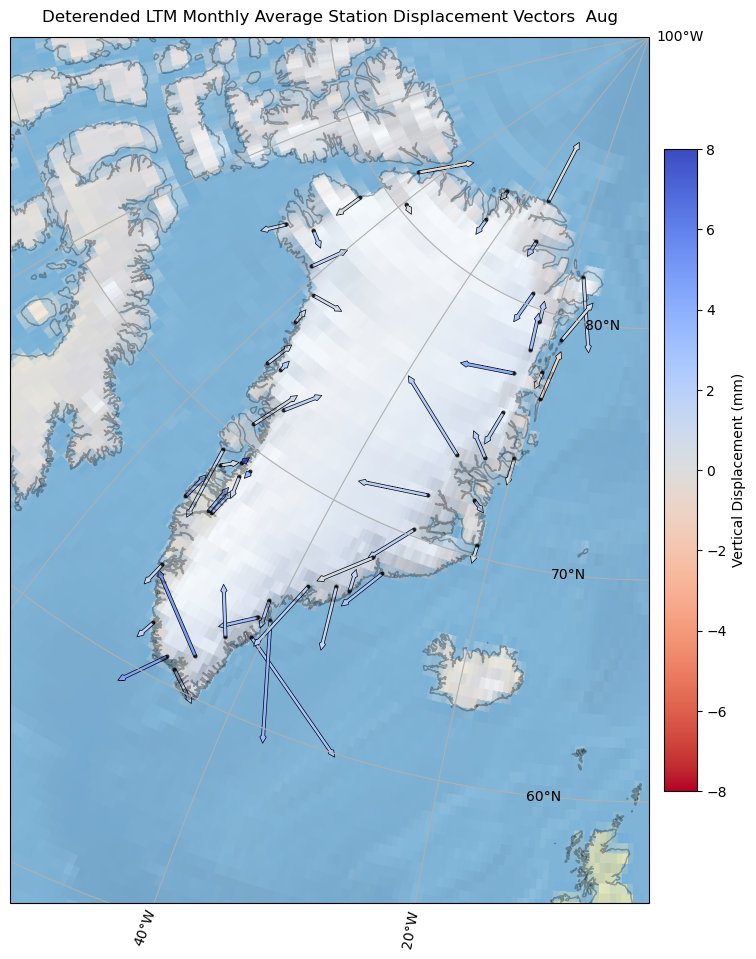

JWLF @ Sep: U=[0.14384772], V=[0.50709826], Mag=[0.52710607]
JGBL @ Sep: U=[0.11392922], V=[-0.0742605], Mag=[0.13599445]
THU2 @ Sep: U=[-0.46449092], V=[-0.27618982], Mag=[0.54040043]
NNVN @ Sep: U=[-1.38460986], V=[1.45423295], Mag=[2.00796861]
YMER @ Sep: U=[-0.40822233], V=[-0.51943198], Mag=[0.66064745]
KMOR @ Sep: U=[0.78401588], V=[0.86196656], Mag=[1.1651898]
BLAS @ Sep: U=[-0.02966861], V=[0.02881577], Mag=[0.04135909]
KLSQ @ Sep: U=[-0.18408618], V=[0.69500463], Mag=[0.71897091]
MARG @ Sep: U=[0.30899586], V=[0.52325524], Mag=[0.60767959]
HRDG @ Sep: U=[0.45806324], V=[-0.22786561], Mag=[0.51160988]
KELY @ Sep: U=[-0.43095919], V=[0.77216204], Mag=[0.88428505]
ILUL @ Sep: U=[-0.01434903], V=[0.3528661], Mag=[0.35315772]
KBUG @ Sep: U=[0.52662284], V=[0.3694191], Mag=[0.6432745]
DGJG @ Sep: U=[-0.862817], V=[0.07577833], Mag=[0.86613829]
WTHG @ Sep: U=[0.05275991], V=[0.356499], Mag=[0.36038194]
AASI @ Sep: U=[0.13362937], V=[0.47506272], Mag=[0.49349914]
HJOR @ Sep: U=[3.7581

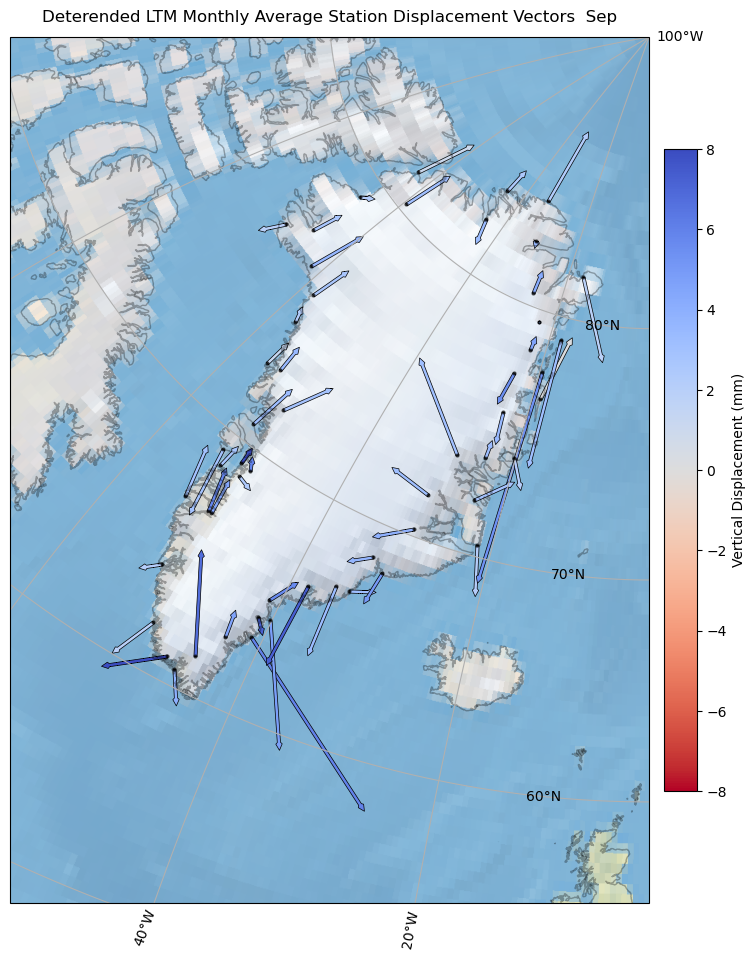

JWLF @ Oct: U=[-0.07165857], V=[0.76579853], Mag=[0.7691439]
JGBL @ Oct: U=[0.09240938], V=[0.12199199], Mag=[0.15304097]
THU2 @ Oct: U=[-0.01936823], V=[0.08674062], Mag=[0.08887667]
NNVN @ Oct: U=[-1.16013946], V=[1.36813455], Mag=[1.79379924]
YMER @ Oct: U=[-0.87004905], V=[-1.00681554], Mag=[1.33066257]
KMOR @ Oct: U=[0.79398923], V=[0.50752945], Mag=[0.94234019]
BLAS @ Oct: U=[-0.5671918], V=[-0.3605606], Mag=[0.6720941]
KLSQ @ Oct: U=[-0.36822517], V=[0.37302759], Mag=[0.52415585]
MARG @ Oct: U=[0.03967908], V=[0.42997013], Mag=[0.43179711]
HRDG @ Oct: U=[0.21860516], V=[-0.10754685], Mag=[0.24362787]
KELY @ Oct: U=[-0.21293144], V=[0.68538914], Mag=[0.71770333]
ILUL @ Oct: U=[-0.11038905], V=[0.71659824], Mag=[0.72505088]
KBUG @ Oct: U=[0.73269968], V=[0.68269872], Mag=[1.00146211]
DGJG @ Oct: U=[-0.38655374], V=[0.32148238], Mag=[0.50276705]
WTHG @ Oct: U=[0.28664565], V=[0.61262633], Mag=[0.67637027]
AASI @ Oct: U=[0.22634097], V=[0.80214233], Mag=[0.83346419]
HJOR @ Oct: U=[2

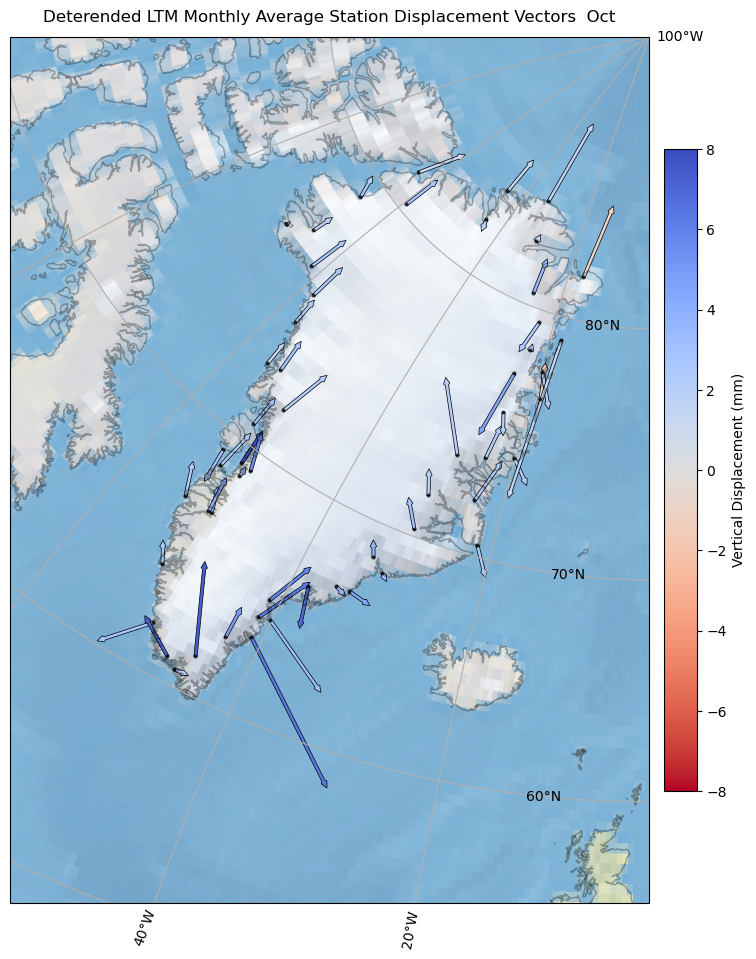

JWLF @ Nov: U=[-0.44548902], V=[0.65262453], Mag=[0.79017671]
JGBL @ Nov: U=[0.08007712], V=[0.11184579], Mag=[0.13755663]
THU2 @ Nov: U=[-0.33755185], V=[-0.13520617], Mag=[0.36362338]
NNVN @ Nov: U=[0.14017818], V=[0.30944277], Mag=[0.33971275]
YMER @ Nov: U=[-0.37425769], V=[-0.09492727], Mag=[0.3861088]
KMOR @ Nov: U=[0.37131561], V=[-0.0303393], Mag=[0.37255302]
BLAS @ Nov: U=[-0.19317461], V=[-0.12299729], Mag=[0.22900822]
KLSQ @ Nov: U=[-0.61664223], V=[-0.64728401], Mag=[0.89399341]
MARG @ Nov: U=[-0.25443088], V=[-0.32346957], Mag=[0.411543]
HRDG @ Nov: U=[-0.09952751], V=[-0.13888429], Mag=[0.17086419]
KELY @ Nov: U=[-0.97614764], V=[-0.06918606], Mag=[0.9785964]
ILUL @ Nov: U=[-0.86290668], V=[0.20368185], Mag=[0.88661956]
KBUG @ Nov: U=[0.38996313], V=[0.40201333], Mag=[0.56007675]
DGJG @ Nov: U=[-0.17900389], V=[0.20303126], Mag=[0.27067339]
WTHG @ Nov: U=[0.28841143], V=[0.37612536], Mag=[0.47397409]
AASI @ Nov: U=[-0.04829554], V=[0.46181021], Mag=[0.46432868]
HJOR @ Nov

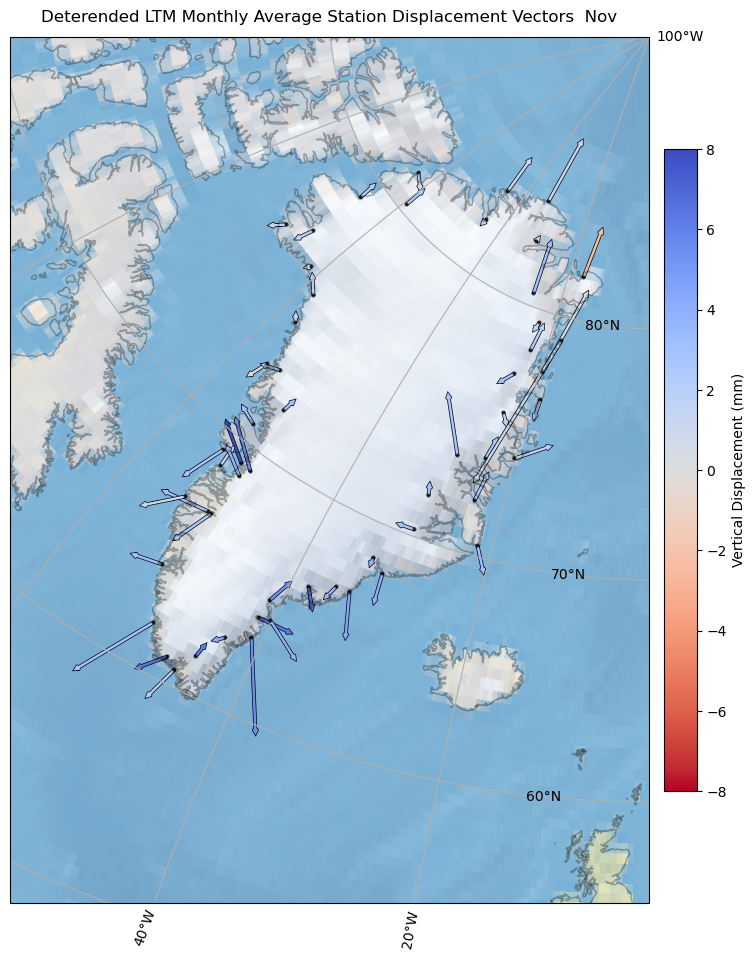

JWLF @ Dec: U=[-0.20777467], V=[0.34748449], Mag=[0.40486514]
JGBL @ Dec: U=[0.09549139], V=[0.27521668], Mag=[0.29131225]
THU2 @ Dec: U=[-0.00909601], V=[-0.06626238], Mag=[0.06688378]
NNVN @ Dec: U=[2.38048942], V=[1.81575336], Mag=[2.99394224]
YMER @ Dec: U=[-0.55955433], V=[-0.49165387], Mag=[0.74486547]
KMOR @ Dec: U=[-0.22990561], V=[0.72837142], Mag=[0.76379416]
BLAS @ Dec: U=[0.19133158], V=[0.0057758], Mag=[0.19141873]
KLSQ @ Dec: U=[-0.62180431], V=[-0.94841821], Mag=[1.13408011]
MARG @ Dec: U=[-0.04421234], V=[-0.30881466], Mag=[0.3119635]
HRDG @ Dec: U=[-0.06596914], V=[-0.13972384], Mag=[0.15451433]
KELY @ Dec: U=[-0.36245392], V=[-0.40836779], Mag=[0.54601932]
ILUL @ Dec: U=[-0.55683734], V=[0.00699618], Mag=[0.55688129]
KBUG @ Dec: U=[0.41831488], V=[0.36246793], Mag=[0.55350731]
DGJG @ Dec: U=[0.15499894], V=[-0.04106724], Mag=[0.16034709]
WTHG @ Dec: U=[0.36179558], V=[0.10898015], Mag=[0.37785277]
AASI @ Dec: U=[0.25370745], V=[0.35572237], Mag=[0.43692777]
HJOR @ Dec

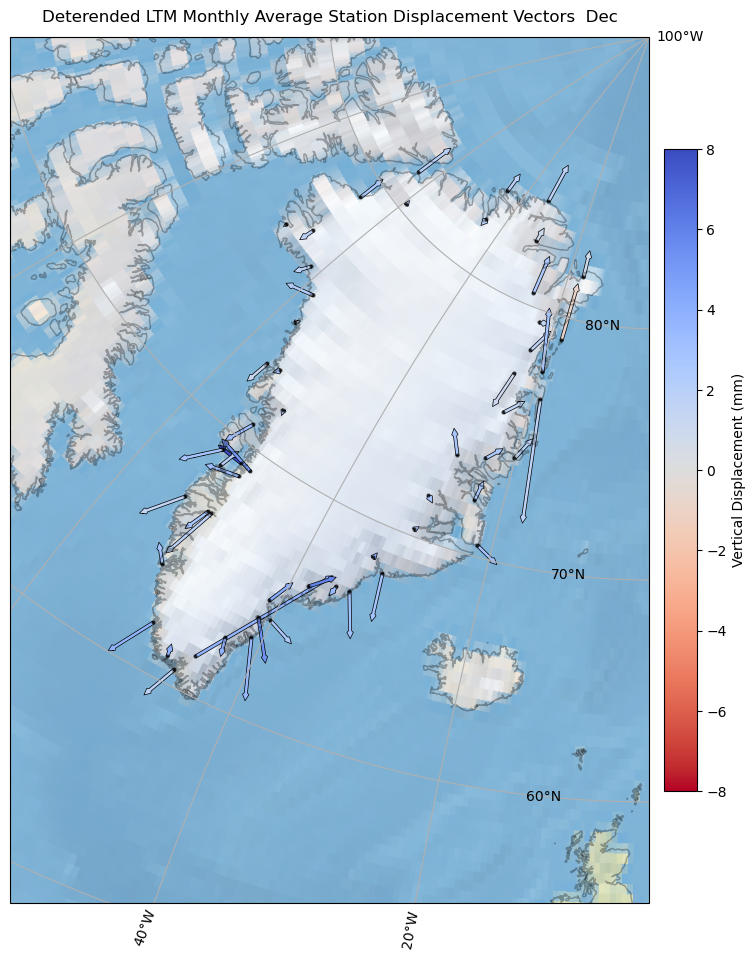

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 1100) to (800, 1104) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x7f96ab304700] Stream #0: not enough frames to estimate rate; consider increasing probesize


In [206]:
Time_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

cmap = cm.coolwarm_r
vmin = -8  # or use np.nanmin of all station 'up' values if precomputed
vmax = 8   # same as above
norm = colors.Normalize(vmin=vmin, vmax=vmax)

filenames = []  

for n, month in enumerate(Time_months):
    fig= plt.figure(figsize=(8,11))
    ax = plt.axes(projection=ccrs.Stereographic())
    plt.title("Deterended LTM Monthly Average Station Displacement Vectors  " + month)

    ax.set_extent([-55, -5, 55, 90])
    ax.gridlines(draw_labels=True)
    ax.stock_img()
    ax.coastlines(resolution='10m', alpha = 0.3)

    for station in stations_names_with_data:
        climatology_monthly = pd.read_csv('/Users/dlugardo/Documents/GitHub/signal-processing-enu/LTM/files/' + station + '_LTM.csv')
        if climatology_monthly.shape[0] == 12:
            smdt = StationMetaData.loc[StationMetaData['station'] == station]

            lon = smdt.longitude
            lat = smdt.latitude

            ax.plot(lon, lat, marker='o', color='black', markersize=2, alpha=0.6, transform=ccrs.Geodetic())
            
            U = np.array([climatology_monthly['east'].iloc[n]])
            V = np.array([climatology_monthly['north'].iloc[n]])
            C = np.array(climatology_monthly['up'].iloc[n]) 

            scale_factor = 12

            ax.quiver(
                lon, lat, U , V ,
                [C],  # color mapped by vertical component
                scale=scale_factor,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                width=0.005,
                alpha=1,
                edgecolor='k',
                linewidth=0.5,
                headwidth=2,         # smaller width
                headlength=2,        # smaller length
                headaxislength=2.5
            )
            magnitude = np.sqrt(U**2 + V**2)
            print(f"{station} @ {month}: U={U}, V={V}, Mag={magnitude}")
        else:
            #print(station + ' has no full LTM data.')
            continue


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # only needed for colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.02)
    cbar.set_label('Vertical Displacement (mm)')


    ref_mm = 1  # reference displacement in mm
    ref_units = ref_mm  # length in plot units

    Q = ax.quiver(
        np.array([0]), np.array([0]),
        np.array([1]), np.array([0]),
        transform=ccrs.PlateCarree(),
        scale=scale_factor,
    )

    ax.quiverkey(
        Q,
        X=0.55, Y=-0.1, U=ref_units,
        label=f'{ref_mm} mm',
        labelpos='E',
        coordinates='axes'
    )

    plt.tight_layout()
    filename = f'/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/PlotsforAnimations/LTM_MapVis_{month}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.show()
    plt.close()
    
with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Annual.gif', mode='I', duration=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/Users/dlugardo/Documents/GitHub/signal-processing-enu/Visualization/LTM_MapVis_Annual.mp4' , fps=1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        